In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import shap
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [41]:
print("Loading dataset...")
df = pd.read_csv('../data/dataset_800.csv', sep=';', decimal=',')
print(f"✅ Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
display(df.head())

Loading dataset...
✅ Data loaded: 800 rows, 9 columns

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Soil_Type               800 non-null    object 
 1   Crop                    800 non-null    object 
 2   Rainfall_mm             800 non-null    float64
 3   Temperature_Celsius     800 non-null    float64
 4   Fertilizer_Used         800 non-null    bool   
 5   Irrigation_Used         800 non-null    bool   
 6   Weather_Condition       800 non-null    object 
 7   Days_to_Harvest         800 non-null    int64  
 8   Yield_tons_per_hectare  800 non-null    float64
dtypes: bool(2), float64(3), int64(1), object(3)
memory usage: 45.4+ KB
None

First 5 rows:


,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,Sandy,Cotton,897.077239,27.676966,False,True,Cloudy,122,6.555816
1,Clay,Rice,992.673282,18.026142,True,True,Rainy,140,8.527341
2,Loam,Barley,147.998025,29.794042,False,False,Sunny,106,1.127443
3,Sandy,Soybean,986.866331,16.644190,False,True,Rainy,146,6.517573
4,Silt,Wheat,730.379174,31.620687,True,True,Cloudy,110,7.248251


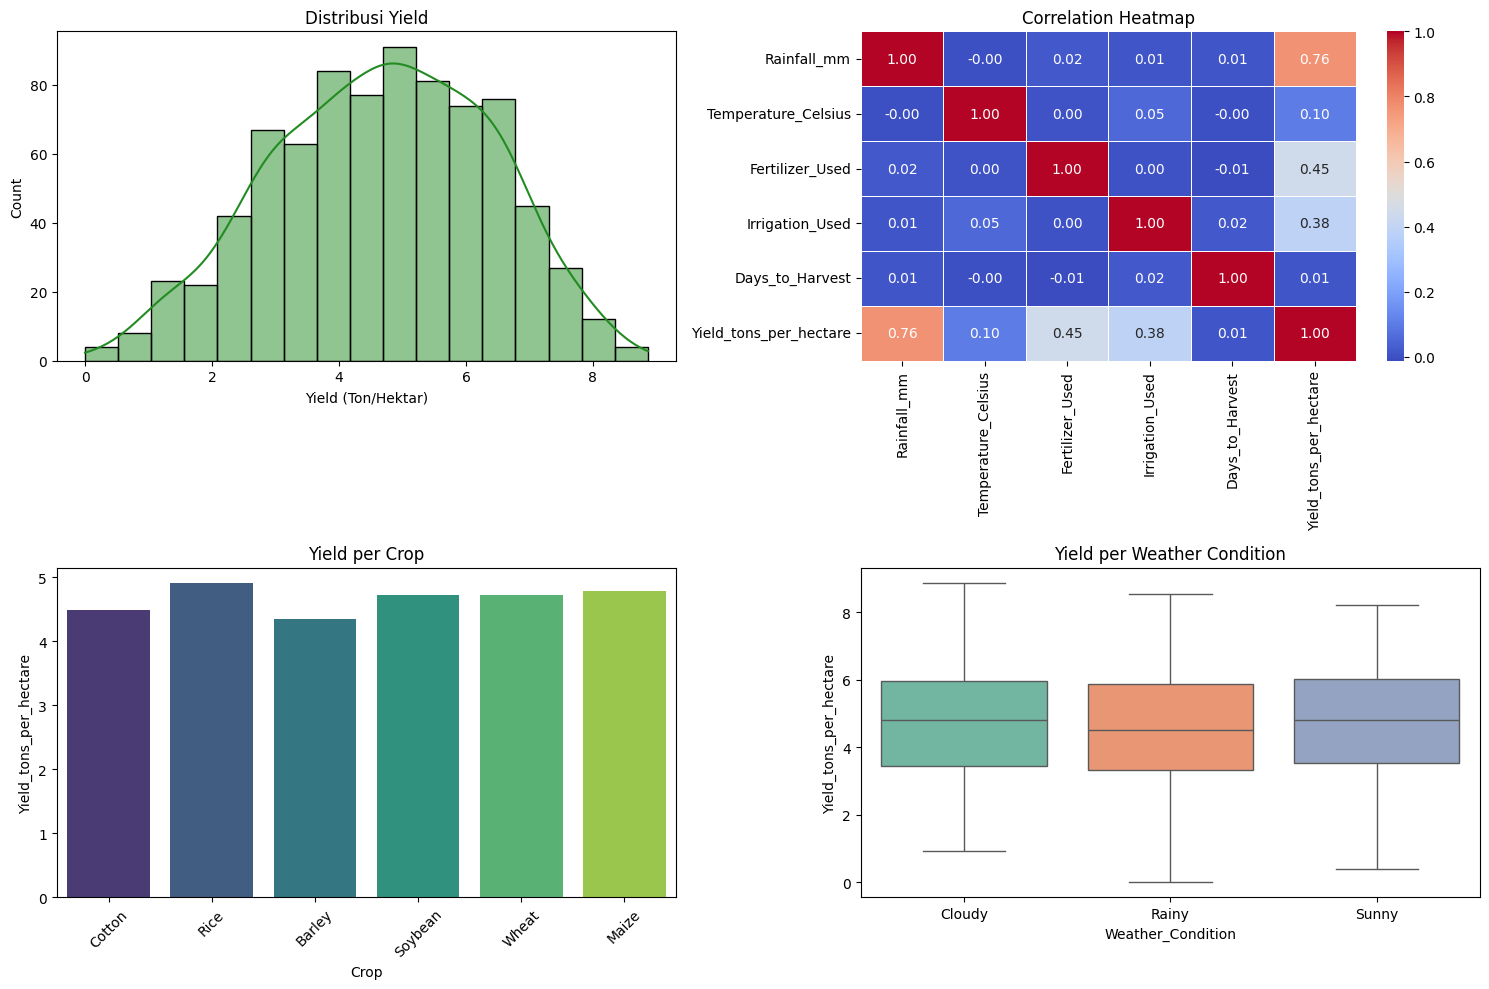

✅ EDA completed!


In [42]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(df['Yield_tons_per_hectare'], kde=True, color='forestgreen', ax=axes[0, 0])
axes[0, 0].set_title('Distribusi Yield')
axes[0, 0].set_xlabel('Yield (Ton/Hektar)')

correlation = df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes[0, 1])
axes[0, 1].set_title('Correlation Heatmap')

sns.barplot(x='Crop', y='Yield_tons_per_hectare', data=df, ax=axes[1, 0], palette='viridis', errorbar=None)
axes[1, 0].set_title('Yield per Crop')
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(x='Weather_Condition', y='Yield_tons_per_hectare', data=df, ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('Yield per Weather Condition')

plt.tight_layout()
plt.show()

print(f"✅ EDA completed!")

In [43]:
X = df.drop(columns=['Yield_tons_per_hectare'])
y = df['Yield_tons_per_hectare']

bool_cols = ['Fertilizer_Used', 'Irrigation_Used']
X[bool_cols] = X[bool_cols].astype(int)

X = pd.get_dummies(X, columns=['Crop', 'Soil_Type', 'Weather_Condition'], drop_first=True)

print(f"✅ Preprocessing completed!")
print(f"Features: {X.shape[1]} (from 9 original columns)")

✅ Preprocessing completed!
Features: 17 (from 9 original columns)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

os.makedirs('../data', exist_ok=True)
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

print(f"✅ Data split & saved!")
print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

✅ Data split & saved!
Train: 640 | Test: 160


In [45]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Performing 5-Fold Cross-Validation...\n")
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
    cv_results[name] = scores
    print(f"{name:15s} | R² = {scores.mean():.4f} (±{scores.std():.4f})")

print("\n✅ Cross-validation completed!")

Performing 5-Fold Cross-Validation...

Decision Tree   | R² = 0.8221 (±0.0164)
Random Forest   | R² = 0.8983 (±0.0137)
XGBoost         | R² = 0.8784 (±0.0150)
LightGBM        | R² = 0.8978 (±0.0069)

✅ Cross-validation completed!


In [46]:
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1]
    },
    'LightGBM': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1]
    }
}

print("Hyperparameter Tuning...\n")
best_models = {}

for name in ['XGBoost', 'LightGBM']:
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    
    print(f"Best params: {grid.best_params_}")
    print(f"Best CV R²: {grid.best_score_:.4f}\n")

print("✅ Hyperparameter tuning completed!")

Hyperparameter Tuning...

Tuning XGBoost...
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best CV R²: 0.9036

Tuning LightGBM...
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best CV R²: 0.9037

✅ Hyperparameter tuning completed!


In [47]:
print("Training all models...\n")

for name, model in models.items():
    if name in best_models:
        models[name] = best_models[name]
    else:
        models[name].fit(X_train, y_train)

print("✅ All models trained!")

Training all models...

✅ All models trained!


In [48]:
results = []

print("\n" + "="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)
print(f"{'Model':<15} {'R²':<10} {'MAE':<10} {'RMSE':<10} {'MAPE':<10}")
print("-"*80)

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    results.append({
        'Model': name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Predictions': y_pred
    })
    
    print(f"{name:<15} {r2:<10.4f} {mae:<10.4f} {rmse:<10.4f} {mape:<10.2f}%")

print("="*80)

results_df = pd.DataFrame(results)
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")


MODEL EVALUATION RESULTS
Model           R²         MAE        RMSE       MAPE      
--------------------------------------------------------------------------------
Decision Tree   0.8137     0.5959     0.7308     16.02     %
Random Forest   0.8889     0.4571     0.5643     12.57     %
XGBoost         0.9053     0.4180     0.5210     11.72     %
LightGBM        0.9009     0.4246     0.5329     12.03     %

🏆 Best Model: XGBoost


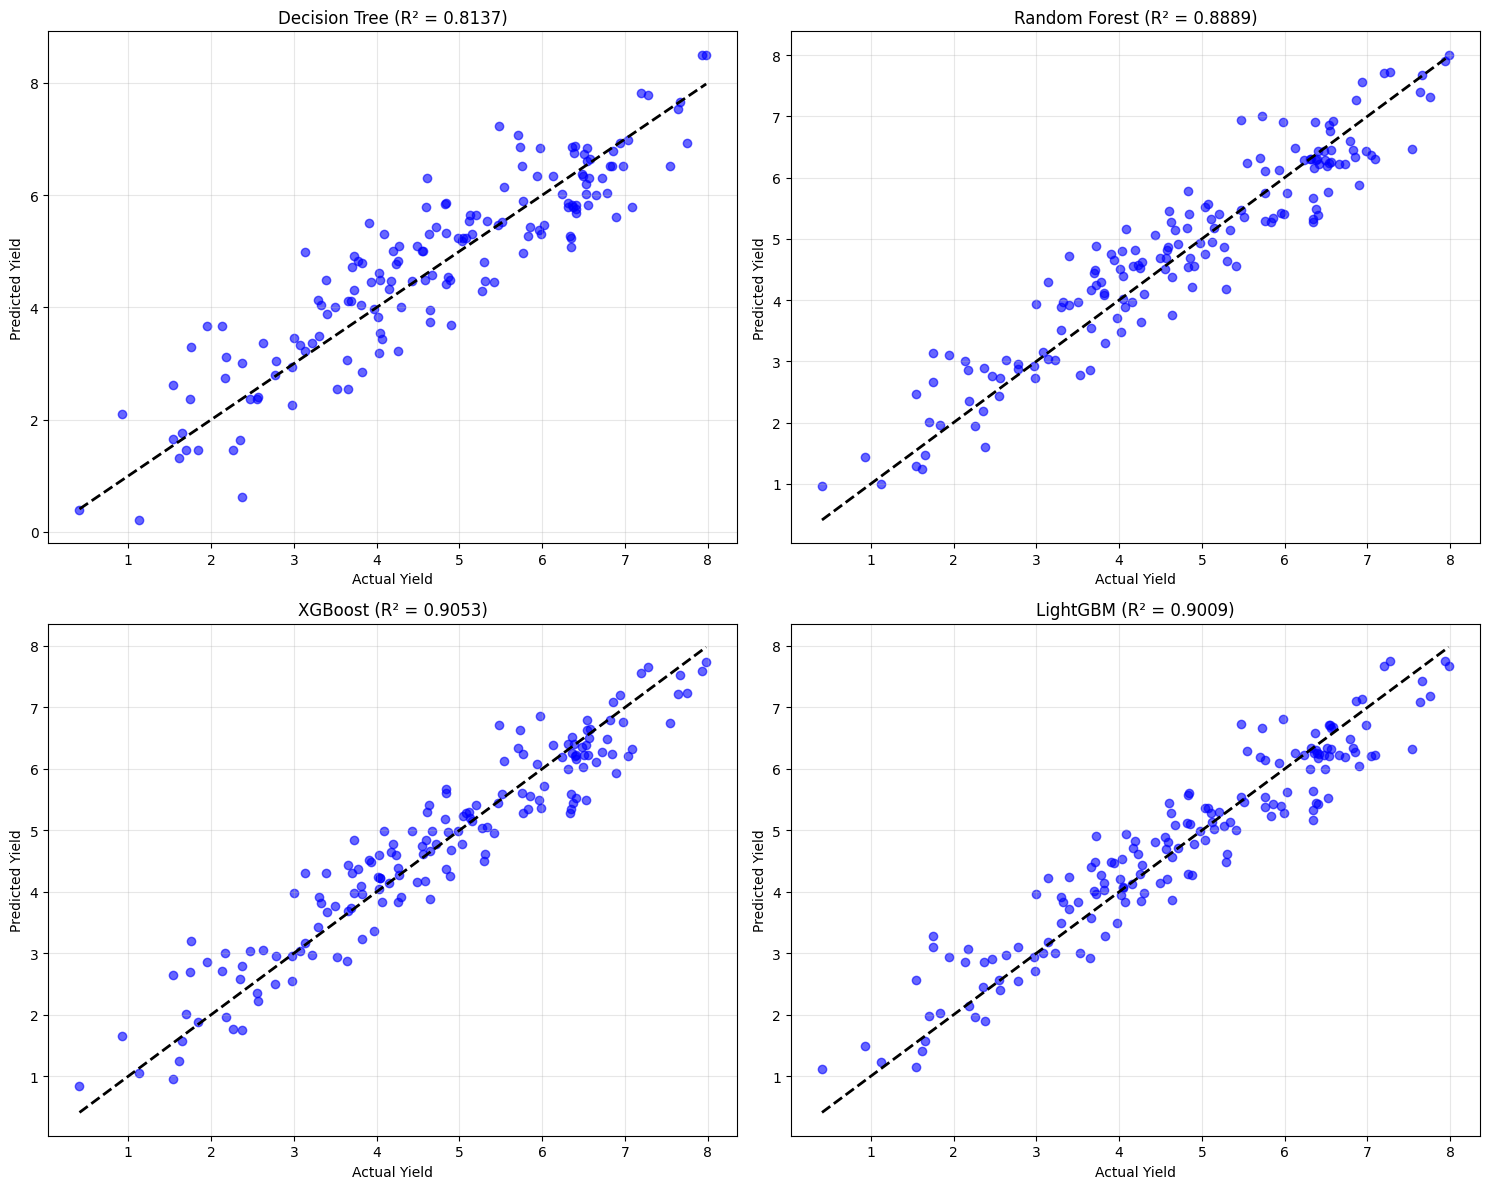

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx // 2, idx % 2]
    y_pred = results_df[results_df['Model'] == name]['Predictions'].values[0]
    r2 = results_df[results_df['Model'] == name]['R²'].values[0]
    
    ax.scatter(y_test, y_pred, alpha=0.6, color='blue')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    ax.set_xlabel('Actual Yield')
    ax.set_ylabel('Predicted Yield')
    ax.set_title(f'{name} (R² = {r2:.4f})')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

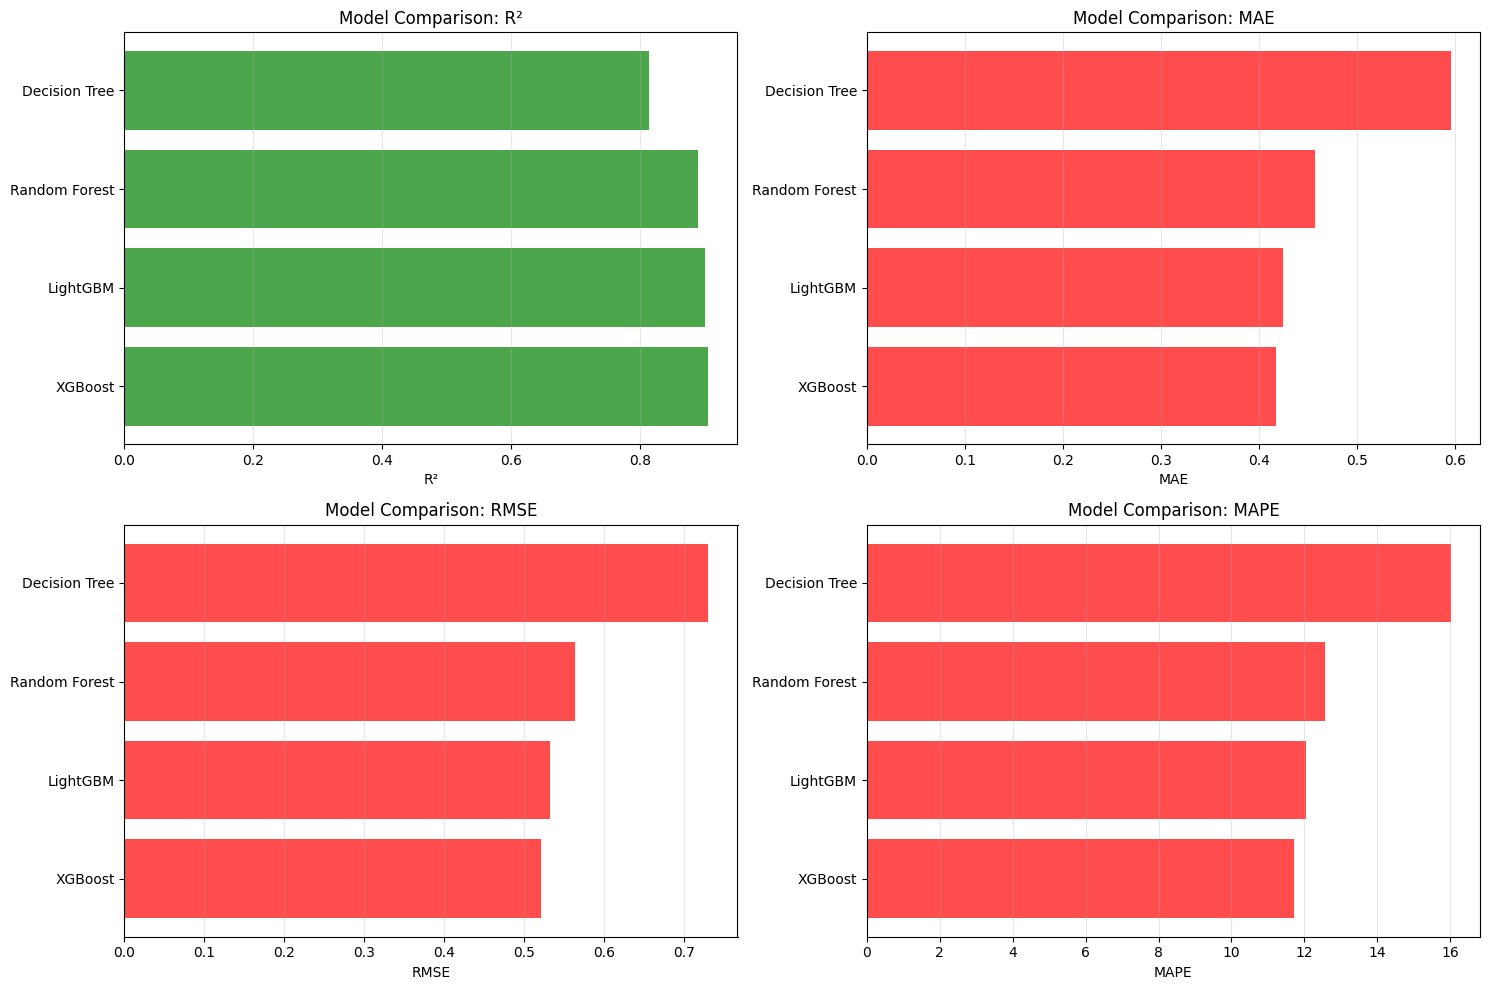

In [50]:
metrics_df = results_df[['Model', 'R²', 'MAE', 'RMSE', 'MAPE']].copy()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, metric in enumerate(['R²', 'MAE', 'RMSE', 'MAPE']):
    ax = axes[idx // 2, idx % 2]
    data = metrics_df.sort_values(metric, ascending=(metric != 'R²'))
    colors = ['green' if metric == 'R²' else 'red'] * len(data)
    ax.barh(data['Model'], data[metric], color=colors, alpha=0.7)
    ax.set_xlabel(metric)
    ax.set_title(f'Model Comparison: {metric}')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [51]:
best_model = models[best_model_name]

print(f"Creating SHAP analysis for {best_model_name}...\n")

X_train_numeric = X_train.astype(float)
X_test_numeric = X_test.astype(float)

explainer = shap.Explainer(best_model, X_train_numeric)
shap_values = explainer(X_test_numeric)

print("✅ SHAP values computed!")

Creating SHAP analysis for XGBoost...

✅ SHAP values computed!


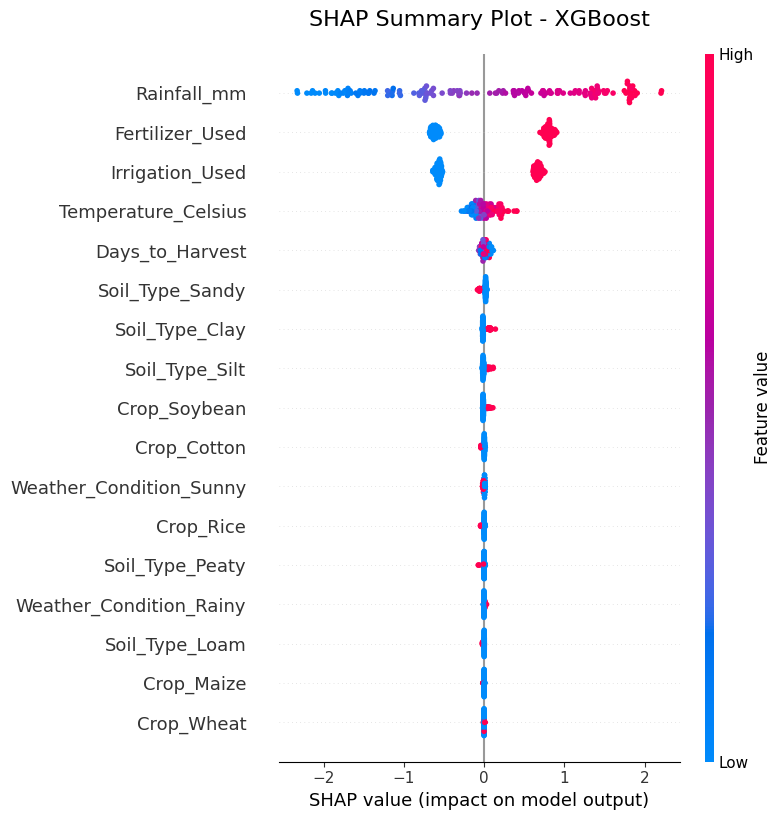

In [52]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_numeric, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

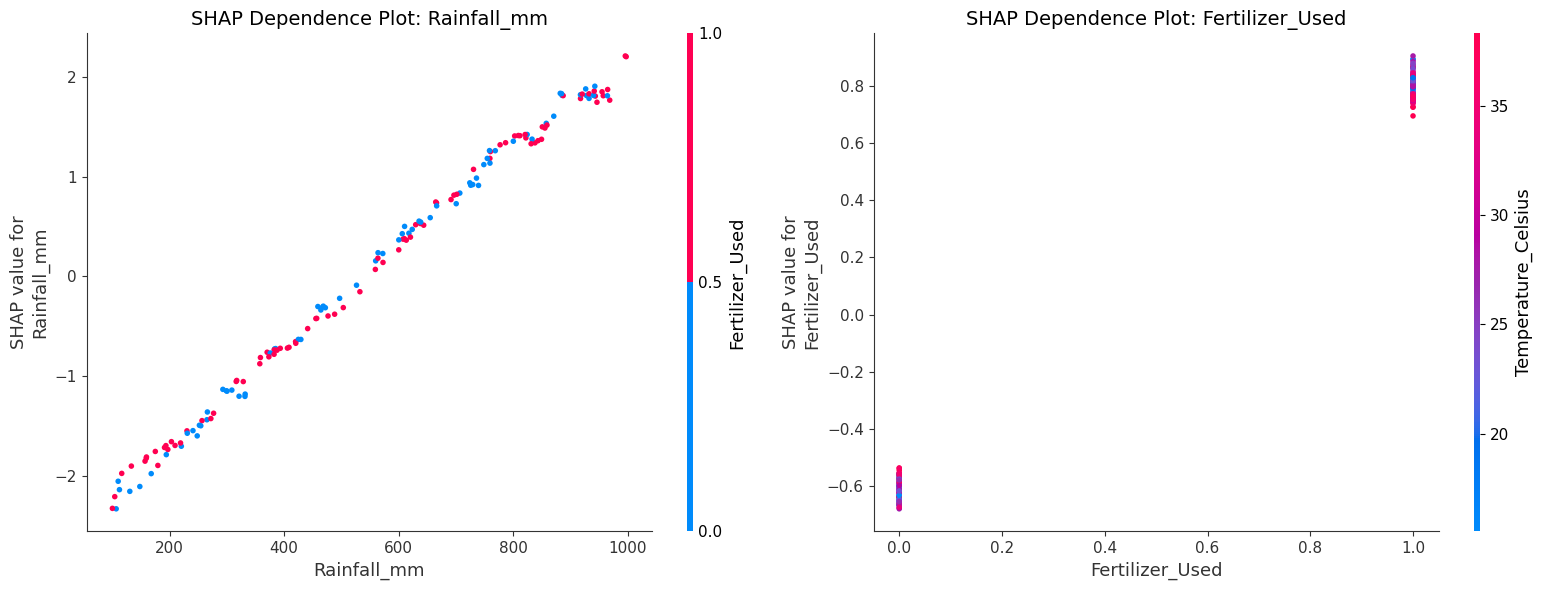

In [53]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(2)['feature'].values

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, feature in enumerate(top_features):
    shap.dependence_plot(
        feature,
        shap_values.values,
        X_test_numeric,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence Plot: {feature}', fontsize=14)

plt.tight_layout()
plt.show()

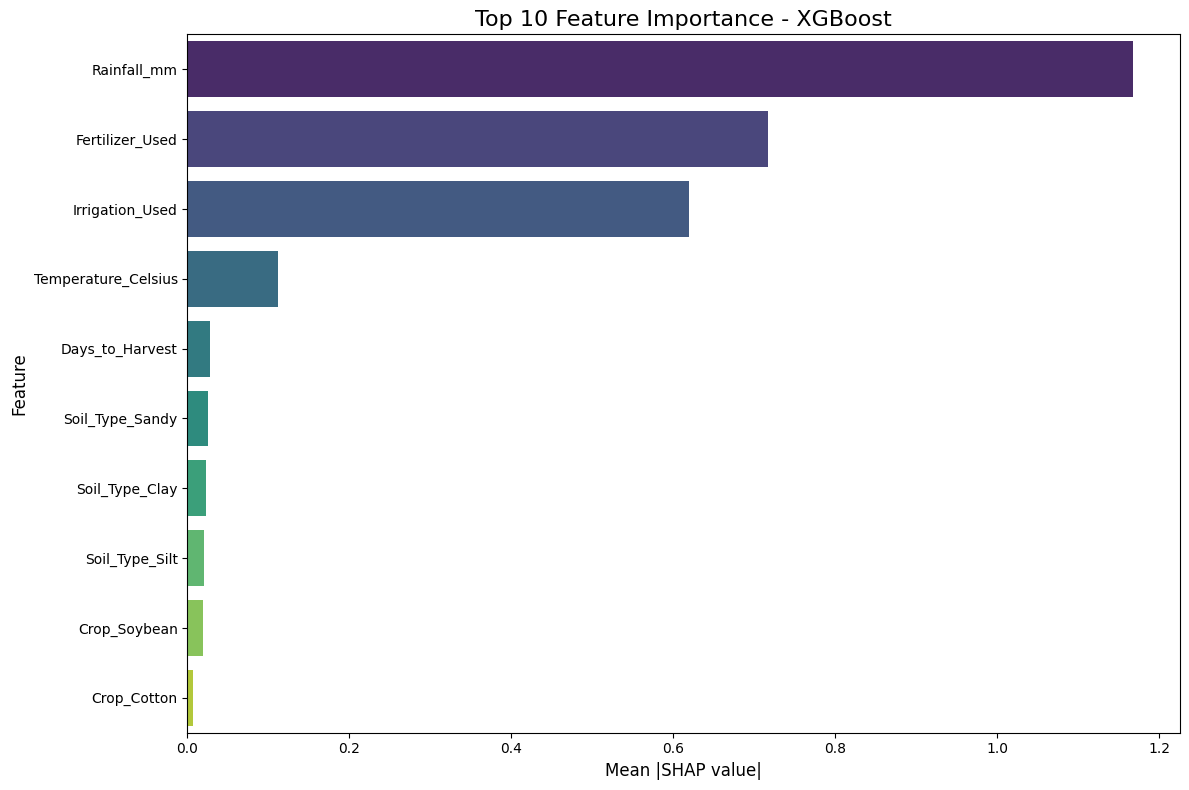


Top 10 Most Important Features:
Rainfall_mm                   : 1.1676
Fertilizer_Used               : 0.7167
Irrigation_Used               : 0.6190
Temperature_Celsius           : 0.1122
Days_to_Harvest               : 0.0282
Soil_Type_Sandy               : 0.0249
Soil_Type_Clay                : 0.0232
Soil_Type_Silt                : 0.0206
Crop_Soybean                  : 0.0194
Crop_Cotton                   : 0.0073


In [54]:
plt.figure(figsize=(12, 8))
top_10 = feature_importance.head(10)
sns.barplot(data=top_10, x='importance', y='feature', palette='viridis')
plt.title(f'Top 10 Feature Importance - {best_model_name}', fontsize=16)
plt.xlabel('Mean |SHAP value|', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print("="*50)
for idx, row in top_10.iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.4f}")
print("="*50)

In [55]:
os.makedirs('../models', exist_ok=True)

print("Saving models...\n")

joblib.dump(models['Decision Tree'], '../models/decision_tree.pkl')
print(f"✅ Decision Tree saved to ../models/decision_tree.pkl")

joblib.dump(models['Random Forest'], '../models/random_forest.pkl')
print(f"✅ Random Forest saved to ../models/random_forest.pkl")

models['XGBoost'].get_booster().save_model('../models/xgboost_model.json')
print(f"✅ XGBoost saved to ../models/xgboost_model.json")

models['LightGBM'].booster_.save_model('../models/lightgbm_model.txt')
print(f"✅ LightGBM saved to ../models/lightgbm_model.txt")

metrics_df.to_csv('../models/model_comparison.csv', index=False)
print("\n✅ Model metrics saved to ../models/model_comparison.csv")
print("\n" + "="*80)
print("🎉 PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nOutput files:")
print("  📊 Data: ../data/X_train.csv, X_test.csv, y_train.csv, y_test.csv")
print("  🤖 Models: ../models/*.pkl, *.json, *.txt")
print("  📈 Metrics: ../models/model_comparison.csv")
print("\n✅ Ready for Streamlit deployment!")

Saving models...

✅ Decision Tree saved to ../models/decision_tree.pkl
✅ Random Forest saved to ../models/random_forest.pkl
✅ XGBoost saved to ../models/xgboost_model.json
✅ LightGBM saved to ../models/lightgbm_model.txt

✅ Model metrics saved to ../models/model_comparison.csv

🎉 PIPELINE COMPLETED SUCCESSFULLY!

Output files:
  📊 Data: ../data/X_train.csv, X_test.csv, y_train.csv, y_test.csv
  🤖 Models: ../models/*.pkl, *.json, *.txt
  📈 Metrics: ../models/model_comparison.csv

✅ Ready for Streamlit deployment!
